## Installing and Importing some necessary modules

In [1]:
# !pip install pytorch-tabnet
# !pip install seaborn
# !pip install lightgbm
# !pip install kaggle
# !pip install pyarrow

In [2]:
import os
import gc
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from contextlib import contextmanager
import time

import numpy as np
import pandas as pd
import scipy as sp
import random

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import torch
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
np.random.seed(0)

from pytorch_tabnet.tab_model import TabNetClassifier ##Import Tabnet 

from pathlib import Path

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

## Seeding all random parameters for reproducibility

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 123
seed_everything(SEED)

## Downloading and Reading the dataset

In [4]:
# os.environ['KAGGLE_CONFIG_DIR'] = '/notebooks/'
# !kaggle datasets download -d abhimanyukarshni/riiid-train

In [5]:
# !unzip riiid-train.zip
# !rm riiid-train.zip

In [6]:
# import data
train = pd.read_feather("riiid_train1.feather").iloc[:30000000].reset_index(drop = True)
val = pd.read_feather("riiid_train1.feather").iloc[30000000:].reset_index(drop = True)

Splitting training dataset into train and validation sets. Then extracting meaningful features for training

In [7]:
TARGET = 'answered_correctly'
# Features to train and predict
FEATURES = ['prior_question_elapsed_time', 'prior_question_had_explanation',
       'answered_correctly_u_avg', 'explanation_u_avg', 'part', 'community',
       'answered_correctly_q_avg', 'explanation_q_avg', 'elapsed_time_q_avg',
       'timestamp_u_recency_1', 'timestamp_u_recency_2',
       'timestamp_u_recency_3', 'timestamp_u_incorrect_recency',
       'num_lectures', 'num_0', 'num_1', 'num_2', 'num_3',
       'answered_correctly_uq_count']

# Shuffle
train = train.sample(30000000)
gc.collect()

drop_cols = list(set(train.columns) - set(FEATURES))
y_train = train[TARGET]
y_val = val[TARGET]
# Drop unnecessary columns
train.drop(drop_cols, axis = 1, inplace = True)
val.drop(drop_cols, axis = 1, inplace = True)
gc.collect()

14

Filling null values with means of the respective features, because TabNet does not accept Nan values

In [8]:
nulls = ['answered_correctly_u_avg', 'explanation_u_avg', 'answered_correctly_q_avg', 'explanation_q_avg', 'elapsed_time_q_avg', 'timestamp_u_recency_1', 'timestamp_u_recency_2', 'timestamp_u_recency_3', 'timestamp_u_incorrect_recency']
for i in nulls:
    m = train[i].dropna().values.mean()
    train[i].fillna(m, inplace = True)
    val[i].fillna(m, inplace = True)

The values of **part** feature range from 1-7, but TabNet accepts only 0 based indexing of features. So I encoded the feature values from 1 based indexing to 0 based indexing.

In [9]:
enc = LabelEncoder()
enc.fit(train.part)
train.part = enc.transform(train.part)
val.part = enc.transform(val.part)

## TabNet Classifier

In [10]:
# part and community are categorical features
cat_idx = [4, 5]
cat_dim = [7, 5]
cat_emb = [5, 5]

clf = TabNetClassifier(seed = SEED,
                       cat_idxs = cat_idx,
                       cat_dims = cat_dim, 
                       cat_emb_dim = cat_emb,
                       scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau,
                       scheduler_params = {"mode":'max', "factor":0.5, "patience":1, "verbose":"True"},
                       device_name = 'cuda'
                       )

Device used : cuda


In [11]:
clf.fit(
            X_train=np.array(train), y_train=np.array(y_train), 
            eval_set = [(np.array(val), np.array(y_val))], 
            eval_metric = ['auc'],
          # 0 for no balancing,1 for automated balancing,dict for custom weights per class
            weights =0, 
          # Maximum number of epochs during training , Default 1000. I used 5
            max_epochs=5,
          # Number of consecutive non improving epoch before early stopping , Default 50
            patience=10, 
          # Training batch size
            batch_size=65536,
          # Batch size for Ghost Batch Normalization (virtual_batch_size < batch_size)
            virtual_batch_size=32768 )


epoch 0  | loss: 0.55482 | val_0_auc: 0.75447 |  0:11:00s
epoch 1  | loss: 0.54708 | val_0_auc: 0.75563 |  0:22:04s
epoch 2  | loss: 0.5464  | val_0_auc: 0.7565  |  0:33:08s
epoch 3  | loss: 0.54587 | val_0_auc: 0.75696 |  0:44:12s
epoch 4  | loss: 0.54546 | val_0_auc: 0.75628 |  0:55:15s
Stop training because you reached max_epochs = 5 with best_epoch = 3 and best_val_0_auc = 0.75696
Best weights from best epoch are automatically used!


In [12]:
clf.save_model('storage/tabnet_30M')

Successfully saved model at storage/tabnet_30M.zip


'storage/tabnet_30M.zip'

In [13]:
# clf.load_model('storage/tabnet_20M')

In [14]:
feature_importance_df = pd.DataFrame()
feature_importance_df["Feature"] = FEATURES
feature_importance_df["importance"] = clf.feature_importances_

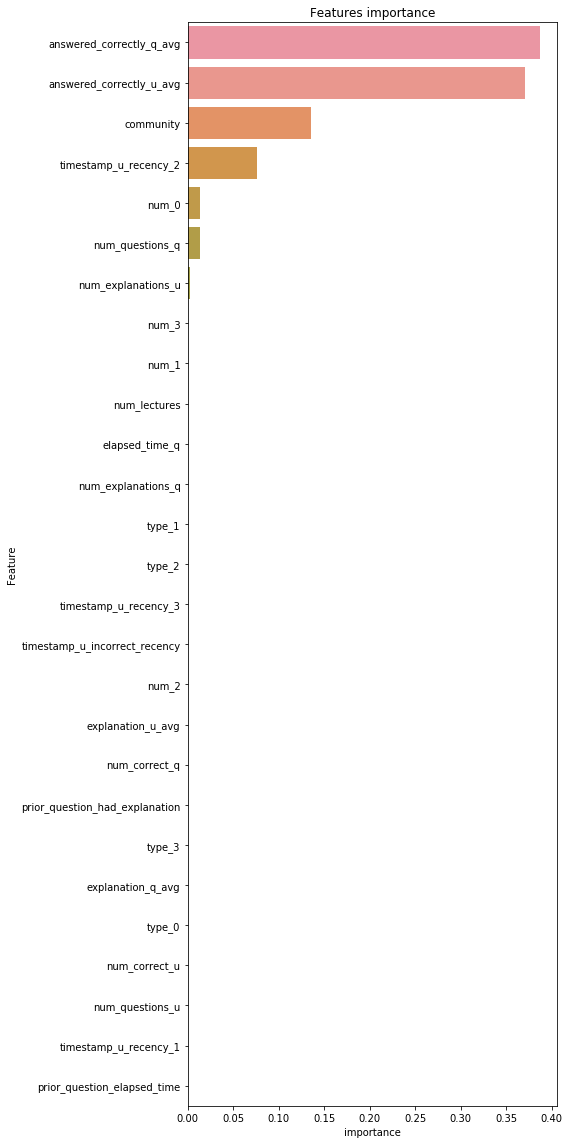

In [15]:
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending = False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(8, 16))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('Features importance')
plt.tight_layout()
plt.savefig('feature_importance_riid.png')